# 03 팩터 투자와 자산 가격 결정 이상 현상

금융 논문의 세계는 크게 둘로 나뉨.

1. 학술 저널, 『Journal of Finance』, 『Review of Financial Studies』, 『Journal of Financial Economics』.
2. 실무자를 위한 논문, 『Journal of Portfolio Management』, 『Financial Analysts Journal』.

## 3.1 개요

팩터 모델의 핵심 목표는 **자산 가격의 동인**을 이해하는 것. 대체로 팩터 투자의 논리는 기업의 재무 성과가 팩터에 의존함.


## 3.2 이상 현상 탐지

### 3.2.1 도전

### 3.2.2 단순 포트폴리오 정렬

가장 일반적인 절차이며, 파마와 프렌치에서 사용한 절차.

어떤 한 날짜에 대해,
1. 특정 기준(ex. 시가총액, 가격 대비 장부가 비율 등)에 따라 기업의 순위를 매긴다.
2. 순위에 따라 동일한 개수의 주식으로 구성된 J개(J >= 2)의 포트폴리오를 구성한다.
3. 포트폴리오 내의 주식 가중치는 균등하거나 시가총액에 비례한다.
4. 미래 날짜(보통 1개월)에 포트폴리오의 수익률을 보고한다. 그런 다음 샘플의 가장 마지막 날짜에 도달할 때까지 이 절차를 반복한다.

Text(0.5, 0, 'year')

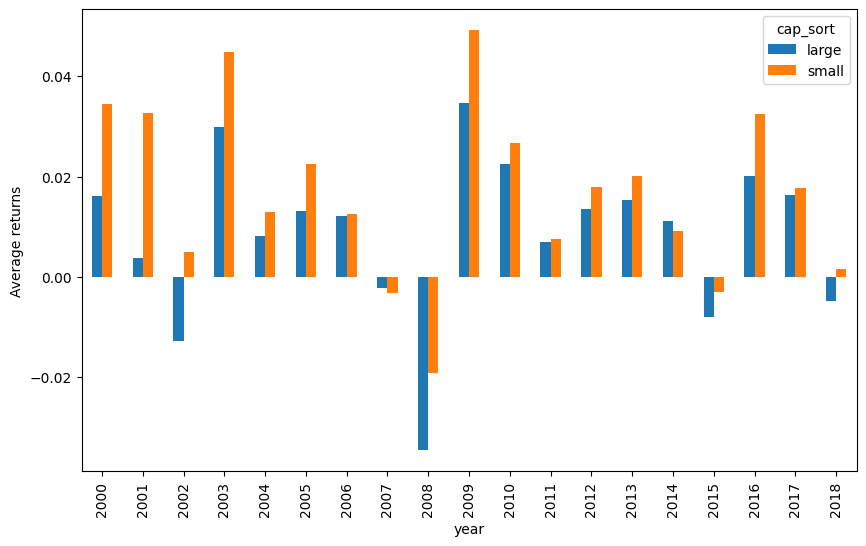

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_raw = pd.read_excel("../data/external/data_ml.xlsx")  # 데이터 불러오기
idx_data = data_raw.index[
    (data_raw["date"] > "1999-12-31") & (data_raw["date"] < "2019-01-01")
].tolist()
# 날짜를 받기 위한 인덱스 생성
# df.iloc[행_위치, 열_위치]: 특정 행과 열의 위치를 숫자로 지정하여 데이터를 선택하는 함수
data_ml = data_raw.iloc[idx_data]

# 임시 데이터프레임을 위한 빈 리스트 생성
df_median = []
df = []

# 사이즈 팩터 포트폴리오 계산
df_median = (
    data_ml[["date", "Mkt_Cap_12M_Usd"]].groupby(["date"]).median().reset_index()
)
df_median.rename(columns={"Mkt_Cap_12M_Usd": "cap_median"}, inplace=True)

df = pd.merge(
    data_ml[["date", "Mkt_Cap_12M_Usd", "R1M_Usd"]], df_median, how="left", on=["date"]
)
df = (
    df.groupby(
        [
            pd.to_datetime(df["date"]).dt.year,
            np.where(df["Mkt_Cap_12M_Usd"] > df["cap_median"], "large", "small"),
        ]
    )["R1M_Usd"]
    .mean()
    .reset_index()
)

df.rename(columns={"level_1": "cap_sort"}, inplace=True)
df.pivot(index="date", columns="cap_sort", values="R1M_Usd").plot.bar(figsize=(10, 6))
plt.ylabel("Average returns")
plt.xlabel("year")

### 3.2.3 팩터들

포트폴리오는 하나의 특성을 기반으로 하며 팩터는 하나의 극단적인 포트폴리오에서 반대되는 극단적인 포트폴리오를 뺀 **롱숏 앙상블.**

- **사이즈**(소형주 - 대형주)
- **밸류**(가치주 - 성장주)
- **모멘텀**(승자주 - 패자주)
- **수익성**(견고한 수익성 - 약한 수익성)
- **투자**(보수적 투자 - 공격적 투자)
- **저위험**(때때로, 베타에 반한 베팅)

저위험 프리미엄을 제외한 대부분의 주요 이상 현상은 케네스 프렌치의 데이터 라이브러리에 보관 및 업데이트됨.

* [케네스 프렌치 데이터 라이브러리](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) (단, 아이디 비번이 있어야 함...)
* 다른 저장소: [AQR 저장소](https://www.aqr.com/Insights/Datasets) 무료로 이용 가능.

In [16]:
import urllib.request

min_date = 196307
max_date = 202003

# 다운로드할 url을 생성(현재 학교 정책 변경으로 다운로드 불가)
# ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp"
# ff_url += "/F-F_Research_Data_5_Factors_2x3_CSV.zip"
# urllib.request.urlretrieve(ff_url, "factors.zip")  # 다운로드

df_ff = pd.read_csv(
    "../data/external/F-F_Research_Data_5_Factors_2x3.csv",
    header=2,
    sep=",",
    quotechar='"',
)
# 1) 컬럼 이름 정리
df_ff.rename(columns={"Unnamed: 0": "date", "Mkt-RF": "MKT_RF"}, inplace=True)

# 2) 'date'가 6자리 숫자인 행만 남기기 (월별 데이터만 추출)
df_ff = df_ff[df_ff["date"].astype(str).str.match(r"^\d{6}$")].copy()

# 3) date를 정수형으로 변환
df_ff["date"] = df_ff["date"].astype(int)

# 4) 팩터 컬럼들을 숫자로 강제 변환
factor_cols = ["MKT_RF", "SMB", "HML", "RMW", "CMA", "RF"]
for c in factor_cols:
    df_ff[c] = pd.to_numeric(df_ff[c], errors="coerce")

# 5) % → 소수로 변환
df_ff[factor_cols] = df_ff[factor_cols] / 100.0

# 6) 원하는 기간만 슬라이싱
mask = (df_ff["date"] >= min_date) & (df_ff["date"] <= max_date)
FF_factors = df_ff.loc[mask].copy()

# 7) 연도 컬럼 추가
FF_factors["year"] = FF_factors["date"].astype(str).str[:4]

FF_factors.iloc[1:6, 0:7]

,date,MKT_RF,SMB,HML,RMW,CMA,RF
1,196308,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,196309,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,196310,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,196311,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
5,196312,0.0183,-0.0210,-0.0002,0.0003,-0.0007,0.0029


Text(0.5, 0, 'date')

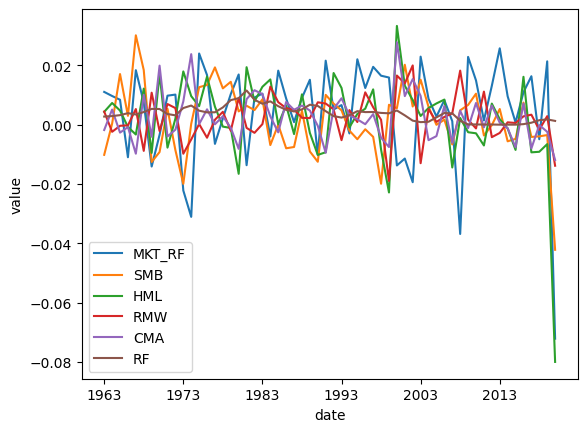

In [18]:
# 연도 및 시가 총액 로직 설정해 그룹화하기
FF_factors.iloc[:, 1:7].groupby(FF_factors["year"]).mean().plot()

# 연도와 팩터별로 그룹화한 뒤, 평균 수익률 계산
plt.ylabel("value")
plt.xlabel("date")